In [10]:
import warnings
warnings.simplefilter(action='ignore')

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import os
import pathlib

from BOW import bow_plus
from scrapeRefine import fetch_preprocess_targets, name_norm, read_zip, merge_news_elections
from data_manipulation import preproc

In [2]:
#PARAMETERS:
load_in = True      #True means don't rebuild, load the premade outfile
out_file ='NEWfull_with_headlines.csv'

In [3]:
dated_df = pd.read_excel("DataIngest/Elections/ElectionDates.xlsx")
dated_df = dated_df[['Year','Date']]
dated_df['Date'] = pd.to_datetime(dated_df.Date).dt.date
dated = dict(zip(dated_df.Year, dated_df.Date))

In [4]:
# President races in the data are split by state;
# And names are last, first instead of first last
# So there should be no confusion
prez_candidates = ["BIDEN, JOSEPH R. JR",
                "CLINTON, HILLARY",
                "BUSH, GEORGE W.",
                "GORE, AL",
                "KERRY, JOHN",
                "MCCAIN, JOHN",
                "OBAMA, BARACK H.",
                "ROMNEY, MITT",
                "TRUMP, DONALD J."
                ]

def file_parser(f, read_path):
    '''From the os.path, we read all the Elections file names
        parsing them for information on the candidates
    '''
    state=None
    target_file = os.path.join(read_path, f)
    
    split_file  = str(f).split('_')
    candidate = split_file[0]
    date = split_file[1]

    prez_check = [p for p in prez_candidates if p in candidate]
    if prez_check:
        assert(len(prez_check) == 1)
        state = candidate.split(prez_check[0])[1].strip()
        candidate = prez_check[0]

    return (target_file, candidate, date, state)

In [5]:
def read_elections():
    elections = []
    for fil in ['1976-2020-president.csv','1976-2020-senate.csv','1976-2020-house.csv']:
        elections.append(fetch_preprocess_targets('DataIngest/Elections/'+fil, dated))
    return pd.concat(elections)

def read_news():
    this_directory = pathlib.Path().absolute()
    read_path = os.path.join(str(this_directory),'DataIngest/NewsData')
    
    news_files = []
    for f in os.listdir(read_path):
        news_files.append(file_parser(f, read_path))

    return_dfs = []
    for tf, can, date, state in news_files:
        if "BLANK VOTE" not in can:
            subfil = read_zip(tf)
            return_dfs.append(pd.read_excel(io.BytesIO(subfil)).assign(file=tf,
                                                                       candidate=can,
                                                                       date=date,
                                                                       state=state))
    return return_dfs

In [6]:
if not load_in:
    elections_df = read_elections()
    election_news = read_news()
print(len(elections_df), len(election_news))

10798 4681


In [9]:
if not load_in:
    news_df, fails_df = merge_news_elections(election_news, elections_df)
    news_df.to_csv(out_file)
else:
    news_df = pd.read_csv(out_file)
print(len(news_df), len(news_df[news_df.headlines != None]))

FAILS 22
10798 10798


In [11]:
whatwehave = preproc(news_df)
whatwehave

num of races: 2561
avg num of participants in a race: 1.9010517278385919


,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,candidatevotes,totalvotes,...,date,candidate_norm,party,candidates,headlines,file,opponents,winner,numcandidates,votedisparity
0,2008,FLORIDA,FL,12,59,43,US PRESIDENT,"OBAMA, BARACK H.",4282074,8390744,...,2008-11-04,OBAMA BARACK H,DEMOCRAT,"OBAMA, BARACK H. ~ MCCAIN, JOHN",comedian dl hughley reviews the news the oppon...,"d:\FALL2022\capstone\NewsData\OBAMA, BARACK H....","MCCAIN, JOHN",True,2,0
1,2004,CALIFORNIA,CA,6,93,71,US HOUSE,DEVIN NUNES,140721,192315,...,2004-11-02,DEVIN NUNES,REPUBLICAN,DEVIN NUNES ~ FRED B DAVIS,graying of congress isnt just your imagination...,d:\FALL2022\capstone\NewsData\DEVIN NUNES_11-2...,FRED B DAVIS,True,2,0
2,2018,MAINE,ME,23,11,2,US SENATE,ERIC L. BRAKEY,223502,634409,...,2018-11-06,ERIC L BRAKEY,REPUBLICAN,"ANGUS S. KING, JR. ~ ERIC L. BRAKEY",america votes democrats hold generic ballot ad...,d:\FALL2022\capstone\NewsData\ERIC L. BRAKEY_1...,"ANGUS S. KING, JR.",False,2,121073
3,2000,NEW MEXICO,NM,35,85,66,US HOUSE,TOM UDALL,135040,201019,...,2000-11-07,TOM UDALL,DEMOCRAT,TOM UDALL ~ LISA L LUTZ,questionandanswer segments with the opponent t...,d:\FALL2022\capstone\NewsData\TOM UDALL_11-7-2...,LISA L LUTZ,True,2,0
4,2018,WYOMING,WY,56,83,68,US SENATE,JOHN BARRASSO,136210,203420,...,2018-11-06,JOHN BARRASSO,REPUBLICAN,JOHN BARRASSO ~ GARY TRAUNER,us sanktionen gegen den iran the opponent maxi...,d:\FALL2022\capstone\NewsData\JOHN BARRASSO_11...,GARY TRAUNER,True,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4654,2016,IOWA,IA,19,42,31,US SENATE,CHUCK GRASSLEY,926007,1541036,...,2016-11-08,CHUCK GRASSLEY,REPUBLICAN,CHUCK GRASSLEY ~ PATTY JUDGE,sen the candidate to hold judiciary committee ...,d:\FALL2022\capstone\NewsData\CHUCK GRASSLEY_1...,PATTY JUDGE,True,2,0
4655,2010,NORTH CAROLINA,NC,37,56,47,US SENATE,RICHARD BURR,1458046,2660079,...,2010-11-02,RICHARD BURR,REPUBLICAN,RICHARD BURR ~ ELAINE MARSHALL,the curtain calls the opponent the opponent th...,d:\FALL2022\capstone\NewsData\RICHARD BURR_11-...,ELAINE MARSHALL,True,2,0
4656,2000,NEW YORK,NY,36,21,13,US HOUSE,C ADRIENNE RHODES,45453,242213,...,2000-11-07,C ADRIENNE RHODES,REPUBLICAN,CAROLYN B MALONEY ~ C ADRIENNE RHODES,voici le bulletin de dix heures the opponent t...,d:\FALL2022\capstone\NewsData\C ADRIENNE RHODE...,CAROLYN B MALONEY,False,2,98356
4657,2020,OKLAHOMA,OK,40,73,53,US SENATE,JIM INHOFE,979140,1556361,...,2020-11-03,JIM INHOFE,REPUBLICAN,JIM INHOFE ~ ABBY BROYLES,reps green lynch and gabbard lead bipartisan f...,d:\FALL2022\capstone\NewsData\JIM INHOFE _11-3...,ABBY BROYLES,True,2,0


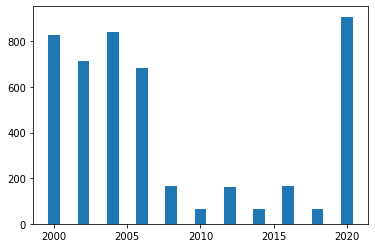

[(2020, 908), (2004, 839), (2000, 830), (2002, 714), (2006, 684), (2016, 167), (2008, 164), (2012, 162), (2018, 64), (2010, 64), (2014, 63)]


In [12]:
from collections import Counter
import matplotlib.pyplot as plt
c_year = Counter(whatwehave['year'])
plt.bar(*zip(*c_year.most_common()))
plt.show()
print(c_year.most_common())

In [55]:
X = bow_plus(whatwehave).drop(columns=['winner'])
y = whatwehave['winner']
vocab = list(X.columns)
X

Parties D, R, I: Counter({1.0: 2363, 0.0: 2237, 2.0: 59})


,aan,aap,aarp,ab,abandon,abandoned,abandoning,abandons,abbott,abc,...,zone,zoom,zs,zu,zuckerberg,zum,zur,zvsan,zwei,PARTYX
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004468,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.008127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
from EasyMLSelector import EasyMLSelector
tmp = X.to_numpy()
M = EasyMLSelector(type_filter="classifier", Xy_tuple=(tmp[:500], y[:500]))
M.split(tmp[:500], y[:500], ts=0.2)
M.model_loop()

Looping all models . . . 


In [ ]:
print(M.best_model)
res = M.test_best()

LogisticRegressionCV()
              precision    recall  f1-score   support

       False       0.76      0.77      0.76        48
        True       0.78      0.77      0.78        52

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



'              precision    recall  f1-score   support\n\n       False       0.76      0.77      0.76        48\n        True       0.78      0.77      0.78        52\n\n    accuracy                           0.77       100\n   macro avg       0.77      0.77      0.77       100\nweighted avg       0.77      0.77      0.77       100\n'

In [58]:
import pickle
with open('pickled//best_unprimed.model','wb') as f:
    pickle.dump(M.best_model, f)
with open('pickled//vocab.pickle','wb') as f:
    pickle.dump(vocab, f)

In [59]:
M.X_train.sum(), len(M.X_train), M.X_train.shape

(2390.760435120984, 400, (400, 10000))

In [60]:
M.y_train.sum(), len(M.y_train), M.y_train.shape

(217, 400, (400,))

In [61]:
M.y_test.sum(), len(M.y_test), M.y_test.shape

(52, 100, (100,))

In [62]:
M.X_test.sum(), len(M.X_test), M.X_test.shape

(607.874270483107, 100, (100, 10000))